<a href="https://colab.research.google.com/github/FlavioIBmec/Case-MMZR/blob/main/Case_MMZR_Q3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Questão 3

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

Questão 3-A)

In [2]:
def baixar_cdi(data_inicio, data_fim):
    # Constrói a URL da API do Banco Central do Brasil para baixar dados do CDI
    url = ("https://api.bcb.gov.br/dados/serie/bcdata.sgs.11/dados"f"?formato=json&dataInicial={data_inicio}&dataFinal={data_fim}")
    return pd.read_json(url)

# Define os períodos para os quais o CDI será baixado
periodos = [("01/01/2010", "31/12/2019"),("01/01/2020", "31/12/2029")]

# Concatena os DataFrames de CDI baixados para cada período
df_cdi = pd.concat([baixar_cdi(inicio, fim) for inicio, fim in periodos])

# Converte a coluna 'data' para o formato datetime
df_cdi["data"] = pd.to_datetime(df_cdi["data"], format="%d/%m/%Y")
# Renomeia a coluna 'valor' para 'CDI'
df_cdi.rename(columns={"valor": "CDI"}, inplace=True)

In [3]:
display(df_cdi)

,data,CDI
0,2010-01-04,0.032927
1,2010-01-05,0.032927
2,2010-01-06,0.032927
3,2010-01-07,0.032927
4,2010-01-08,0.032927
...,...,...
1520,2026-01-21,0.055131
1521,2026-01-22,0.055131
1522,2026-01-23,0.055131
1523,2026-01-26,0.055131


In [ ]:
cnpj_fundo = "36.671.748/0001-63" # CNPJ do fundo ALLOCATION RETORNO ABSOLUTO FIC FIM
inicio = "2021-01" # Define o mês de início para a coleta de dados do fundo, levando em conta que o fundo 'nasceu' em 04-01-2021
fim = "2026-02" # Define o mês de fim para a coleta de dados do fundo

# Cria um intervalo de períodos mensais para iterar e baixar os dados
periodos = pd.period_range(inicio, fim, freq = "M")

dfs = [] # Lista para armazenar os DataFrames de cada mês

for p in periodos:
    # Constrói a URL para baixar o arquivo ZIP de informações diárias do fundo da CVM
    url = ("https://dados.cvm.gov.br/dados/FI/DOC/INF_DIARIO/DADOS/"f"inf_diario_fi_{p.year}{p.month:02d}.zip")

    try:
        print(f"Lendo {p.year}-{p.month:02d}...") # Imprime o mês que está sendo lido
        # Lê o arquivo CSV dentro do ZIP, especificando o separador e a codificação
        temp = pd.read_csv(url,sep=';',encoding='latin1',low_memory=False)

        # Verifica qual coluna contém o CNPJ do fundo (pode variar entre 'CNPJ_FUNDO' ou 'CNPJ_FUNDO_CLASSE')
        if 'CNPJ_FUNDO' in temp.columns:
            col_cnpj = 'CNPJ_FUNDO'
        elif 'CNPJ_FUNDO_CLASSE' in temp.columns:
            col_cnpj = 'CNPJ_FUNDO_CLASSE'
        else:
            # Se a coluna de CNPJ não for encontrada, levanta um erro
            raise ValueError("Coluna de CNPJ não encontrada")

        # Filtra o DataFrame para incluir apenas os registros do fundo desejado
        temp = temp[temp[col_cnpj] == cnpj_fundo]

        # Se o DataFrame filtrado não estiver vazio, adiciona-o à lista de DataFrames
        if not temp.empty:
            dfs.append(temp)

    except Exception as e:
        # Em caso de erro durante o download ou processamento, imprime uma mensagem de erro
        print(f"Erro em {p.year}-{p.month:02d}: {e}")


# Concatena todos os DataFrames da lista 'dfs' em um único DataFrame 'df_fundo'
df_fundo = pd.concat(dfs, ignore_index=True)
# Converte a coluna 'DT_COMPTC' para o formato datetime
df_fundo['DT_COMPTC'] = pd.to_datetime(df_fundo['DT_COMPTC'])
# Ordena o DataFrame pelas datas da coluna 'DT_COMPTC'
df_fundo = df_fundo.sort_values('DT_COMPTC')

In [5]:
# Seleciona apenas as colunas 'DT_COMPTC' e 'VL_QUOTA'
df_fundo = df_fundo[['DT_COMPTC', 'VL_QUOTA']]
# Renomeia a coluna 'DT_COMPTC' para 'data'
df_fundo = df_fundo.rename(columns={'DT_COMPTC': 'data'})
df_fundo.head()

,data,VL_QUOTA
0,2021-01-04,1.000000
1,2021-01-05,1.000041
2,2021-01-06,1.000087
3,2021-01-07,1.000134
4,2021-01-08,1.000176


In [6]:
# Combina os DataFrames 'df_fundo' e 'df_cdi' pela coluna 'data'
df = pd.merge(df_fundo, df_cdi, on='data', how='inner')
# Calcula a performance normalizada da VL_QUOTA, começando em 0% e em formato percentual
df['VL_QUOTA_NORMALIZADO'] = ((df['VL_QUOTA'] / df['VL_QUOTA'].iloc[0]) - 1) * 100
df.tail()

,data,VL_QUOTA,CDI,VL_QUOTA_NORMALIZADO
1276,2026-01-20,1.478181,0.055131,47.818095
1277,2026-01-21,1.483640,0.055131,48.363955
1278,2026-01-22,1.486958,0.055131,48.695804
1279,2026-01-23,1.486958,0.055131,48.695804
1280,2026-01-26,1.486958,0.055131,48.695804


In [7]:
# Calcula o CDI acumulado ao longo do tempo
df['CDI_ACUMULADO'] = (1 + df['CDI'] / 100).cumprod()
# Calcula a performance normalizada do CDI, começando em 0% e em formato percentual
df['CDI_NORMALIZADO'] = ((df['CDI_ACUMULADO'] / df['CDI_ACUMULADO'].iloc[0]) - 1) * 100

Questão 3-B)

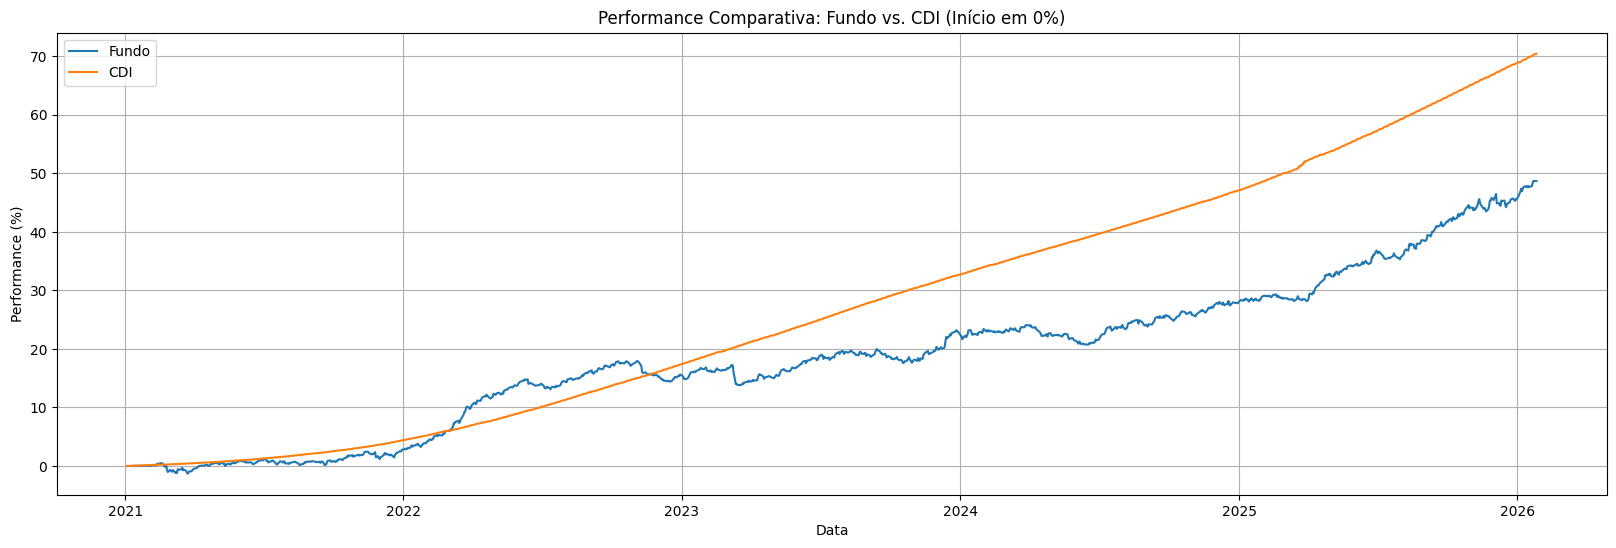

In [8]:
plt.figure(figsize=(20,6))
plt.plot(df['data'], df['VL_QUOTA_NORMALIZADO'], label='Fundo')
plt.plot(df['data'], df['CDI_NORMALIZADO'], label='CDI')

plt.xlabel('Data')
plt.ylabel('Performance (%)')
plt.title('Performance Comparativa: Fundo vs. CDI (Início em 0%)')
plt.legend()
plt.grid(True)
plt.show()